In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from jupyterthemes import jtplot
import seaborn as sns
jtplot.style()
import warnings
warnings.filterwarnings('ignore')

# Prepare the data

## Download the data

In [2]:
! wget -N http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz
! wget -N http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
! mv kddcup* data
! echo n | gunzip data/kddcup.data_10_percent.gz

--2020-10-15 11:37:05--  http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz
Resolving localhost (localhost)... ::1, 127.0.0.1
Connecting to localhost (localhost)|::1|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2144903 (2,0M) [application/x-gzip]
Saving to: ‘kddcup.data_10_percent.gz’

kddcup.data_10_perc 100%[===================>]   2,04M  2,88MB/s    in 0,7s    

2020-10-15 11:37:06 (2,88 MB/s) - ‘kddcup.data_10_percent.gz’ saved [2144903/2144903]

--2020-10-15 11:37:07--  http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
Resolving localhost (localhost)... ::1, 127.0.0.1
Connecting to localhost (localhost)|::1|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1307 (1,3K)
Saving to: ‘kddcup.names’

kddcup.names        100%[===================>]   1,28K  --.-KB/s    in 0s      

2020-10-15 11:37:07 (138 MB/s) - ‘kddcup.names’ saved [1307/1307]

gunzip: data/kddcup.data_10_percent already exists -- skipping


## Read the Data

In [3]:
def load_df(
    file_path="data/kddcup.data_10_percent", 
    header_file="data/kddcup.names",
    sample=1
):
    with open(header_file) as header_file:
        header_raw = header_file.readlines()
    column_names = [h.split(':')[0] for h in header_raw[1:]]
    df = pd.read_csv(file_path, names=column_names)
    return df.sample(frac=sample)

In [4]:
df = load_df()

In [5]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,tcp,private,S0,0,0,0,0,0,0,0,...,7,0.03,0.09,0.0,0.0,1.0,1.0,0.0,0.0,neptune.
0,icmp,ecr_i,SF,520,0,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.
469,udp,domain_u,SF,111,44,0,0,0,0,0,...,62,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,normal.
0,tcp,private,S0,0,0,0,0,0,0,0,...,6,0.02,0.06,0.0,0.0,1.0,1.0,0.0,0.0,neptune.
0,icmp,ecr_i,SF,1032,0,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.


## Choose the anomalous class

<AxesSubplot:xlabel='dst_host_srv_rerror_rate', ylabel='index'>

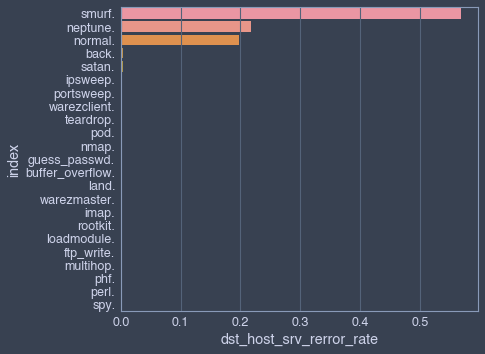

In [6]:
# Calculate the frequency for each class
intrusion_types_freq = df["dst_host_srv_rerror_rate"].value_counts() / df.count()[0]
sns.barplot(
    data=intrusion_types_freq.to_frame().reset_index(), 
    x='dst_host_srv_rerror_rate', 
    y='index'
)


`smurf` and `neptune` are DDOS attack type and for this reason the number of these connections are greater than the number of the normal connections.

For the sake of our exercise, thoese two classes are going to be dropped from the dataset.

So, At this point we can say that anomalies are records that are classified as normal

In [7]:
def prepare_dataset(df, anomaly_prob=.008):
    # Remove DDOS Classes
    df = df[~df["dst_host_srv_rerror_rate"].isin(["smurf.", "neptune."])]
    df["anomaly"] = (df["dst_host_srv_rerror_rate"] != "normal.").astype(int)
    df_anomaly = df[df["anomaly"] == 1]
    df_normal = df[df["anomaly"] == 0]

    df_anomaly = df_anomaly.sample(int(df_normal.count()[0] * anomaly_prob))
    # merge the two df
    df = df_normal.append(df_anomaly)
    # shuffle
    df = df.sample(frac=1).reset_index(drop=True)
    
    # Remove original column
    df = df.drop('dst_host_srv_rerror_rate', axis=1)

    return df

In [8]:
df = prepare_dataset(df)

## Categorical features encoding

In [9]:
df.dtypes[df.dtypes==object]

duration         object
protocol_type    object
service          object
dtype: object

### duration

In [10]:
df["duration"].value_counts()

tcp     77351
udp     19293
icmp     1412
Name: duration, dtype: int64

Only 3 values, good candidate for one-hot-encoding

### protocol_type

In [11]:
df["protocol_type"].value_counts()

http        62076
smtp         9598
private      7595
domain_u     5862
other        5764
ftp_data     3854
urp_i         537
eco_i         495
finger        469
ftp           398
ntp_u         380
ecr_i         363
telnet        232
auth          220
pop_3          79
time           53
IRC            42
urh_i          14
X11             9
domain          3
tim_i           2
sunrpc          2
ssh             2
tftp_u          1
whois           1
shell           1
red_i           1
printer         1
netstat         1
supdup          1
Name: protocol_type, dtype: int64

<AxesSubplot:>

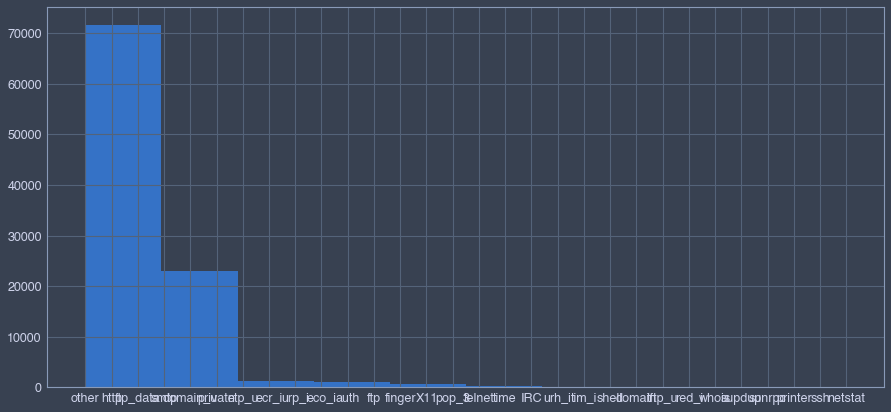

In [12]:
df["protocol_type"].hist(figsize=(15,7))

66 unique values, where multiple values have very low chance of appearing... It could make sense to use mean encoding for this one

### service

In [13]:
df["service"].value_counts()

SF        92211
REJ        5484
RSTR        121
RSTO         76
S0           68
S1           55
S2           19
SH           12
S3            7
OTH           2
RSTOS0        1
Name: service, dtype: int64

mean encoding is also fine here probably, maybe one hot can do it as well

## Numeric features

In [14]:
df.describe()[df.describe().columns[:20]]

,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count
count,9.805600e+04,9.805600e+04,98056.000000,98056.000000,98056.000000,98056.000000,98056.000000,98056.000000,98056.000000,98056.000000,98056.000000,98056.000000,98056.000000,98056.000000,98056.000000,98056.0,98056.0,98056.000000,98056.000000,98056.000000
mean,1.567531e+03,3.532055e+03,0.000031,0.003080,0.000041,0.054581,0.000255,0.716050,0.030279,0.000286,0.000173,0.055805,0.004742,0.000449,0.004977,0.0,0.0,0.004039,8.821459,10.935343
std,5.271327e+04,4.702842e+04,0.005531,0.094252,0.010099,0.954334,0.022353,0.450915,4.031032,0.016896,0.017197,4.512039,0.202297,0.021178,0.081015,0.0,0.0,0.063421,24.924944,21.798120
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
25%,1.460000e+02,1.320000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,1.000000
50%,2.300000e+02,4.150000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,3.000000,4.000000
75%,3.130000e+02,2.125000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,10.000000,13.000000
max,5.133876e+06,5.150938e+06,1.000000,3.000000,3.000000,30.000000,4.000000,1.000000,884.000000,1.000000,2.000000,993.000000,28.000000,1.000000,8.000000,0.0,0.0,1.000000,511.000000,510.000000


In [15]:
col_to_log_scale = ["flag"]

In [16]:
df.describe()[df.describe().columns[20:]]

,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,anomaly
count,98056.000000,98056.000000,98056.000000,98056.000000,98056.000000,98056.000000,98056.000000,98056.000000,98056.000000,98056.000000,98056.000000,98056.000000,98056.000000,98056.000000,98056.000000,98056.000000,98056.000000,98056.000000
mean,0.001959,0.002099,0.057966,0.058387,0.983919,0.019677,0.133900,148.710645,201.134291,0.842446,0.058639,0.136193,0.024796,0.002476,0.001374,0.059832,0.057826,0.007934
std,0.031677,0.031798,0.232508,0.231710,0.099952,0.122297,0.278601,103.478859,87.657267,0.308143,0.185087,0.283744,0.054626,0.032327,0.023311,0.228356,0.222777,0.088721
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,38.000000,166.000000,0.910000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,161.000000,255.000000,1.000000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.120000,255.000000,255.000000,1.000000,0.010000,0.080000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Numerical Features looks pretty much ok, most of them should be good with a min-max scale.
the `flag` feature looks a bit bad, it will probably require some log normalization

<AxesSubplot:>

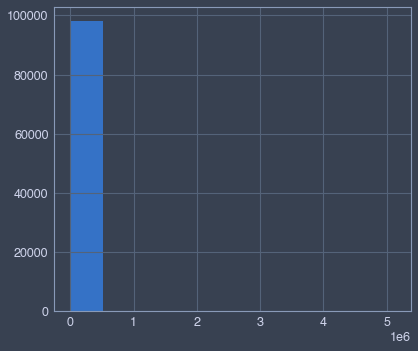

In [17]:
df["flag"].hist()

<AxesSubplot:>

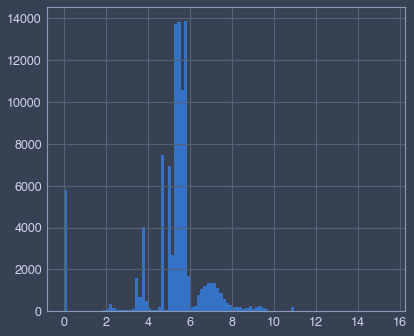

In [18]:
df["flag"].apply(np.log1p).hist(bins=100)

It's something

In [19]:
df["flag"].value_counts()

105      7370
0        5775
147      2725
146      2033
42       1069
         ... 
5661        1
3614        1
11866       1
11994       1
3742        1
Name: flag, Length: 3261, dtype: int64

## Defining the Preprocessor:

In [20]:
from sklearn_pandas import DataFrameMapper, NumericalTransformer
from sklearn import preprocessing
import category_encoders as ce


In [21]:
pre_processor = DataFrameMapper(
    [
        ('duration', preprocessing.LabelBinarizer()),
        ('service', preprocessing.LabelBinarizer()),        
        (['flag'], [NumericalTransformer('log1p'), preprocessing.MinMaxScaler()]),
        (['protocol_type'], [ce.count.CountEncoder(), preprocessing.MinMaxScaler()])
    ],
    default=preprocessing.MinMaxScaler()
)

In [22]:
pre_processor.fit_transform(df)

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [23]:
pre_processor.fit_transform(df).shape

(98056, 53)

# Train:

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
# Train-Test split
# df = df.sample(frac=.1)
df = prepare_dataset(load_df())
X = df.drop('anomaly', axis=1)
y = df['anomaly']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying preprocess
X_train_preprocessed = pre_processor.fit_transform(X_train)
X_test_preprocessed = pre_processor.transform(X_test)

# Remove NaNs
X_train_preprocessed, X_test_preprocessed = np.nan_to_num(X_train_preprocessed), np.nan_to_num(X_test_preprocessed)

In [26]:
from pyod.models.lof import LOF
from pyod.models.hbos import HBOS
from pyod.models.knn import KNN
from pyod.models.cblof import CBLOF
from pyod.models.iforest import IForest
from sklearn.metrics import roc_auc_score

import time

# Models
models = [
    {
        "name": "AvgKNN",
        "model": KNN(method='mean', n_jobs=-1)
    },
    {
        "name": "LOF",
        "model": LOF(n_jobs=-1)
    },
    {
        "name": "CBLOF",
        "model": CBLOF(n_jobs=-1)
    },
    {
        "name": "HBOS",
        "model": HBOS()
    },
    {
        "name": "IForest",
        "model": IForest(n_jobs=-1)
    },
]

for model in models:
    # Train
    start = time.time()
    model["model"].fit(X_train_preprocessed)
    end = time.time()
    model["fitting_time"] = end - start
    
    # Evaluate
    y_pred = model["model"].predict_proba(X_test_preprocessed)[:,1]
    model["score"] = roc_auc_score(y_test, y_pred)
    
    print(f"Finishing training {model['name']}")
    print(f"AUC={model['score']}")
    print(f"Training Time={model['fitting_time']}")
    print("-" * 20)

Finishing training AvgKNN
AUC=0.6803205433368245
Training Time=71.97883820533752
--------------------
Finishing training LOF
AUC=0.618532482782697
Training Time=75.2419421672821
--------------------
Finishing training CBLOF
AUC=0.9252194611063506
Training Time=2.7598299980163574
--------------------
Finishing training HBOS
AUC=0.8577669872100036
Training Time=1.68231201171875
--------------------
Finishing training IForest
AUC=0.9269595988447745
Training Time=6.109901666641235
--------------------


In [27]:
training_results = pd.DataFrame(models)

In [32]:
training_results.drop('model', axis=1)

,name,fitting_time,score
0,AvgKNN,71.978838,0.680321
1,LOF,75.241942,0.618532
2,CBLOF,2.759830,0.925219
3,HBOS,1.682312,0.857767
4,IForest,6.109902,0.926960


In [33]:
print(training_results.drop('model', axis=1).to_markdown())

|    | name    |   fitting_time |    score |
|---:|:--------|---------------:|---------:|
|  0 | AvgKNN  |       71.9788  | 0.680321 |
|  1 | LOF     |       75.2419  | 0.618532 |
|  2 | CBLOF   |        2.75983 | 0.925219 |
|  3 | HBOS    |        1.68231 | 0.857767 |
|  4 | IForest |        6.1099  | 0.92696  |


## Training Results (static)
|    | name    |   fitting_time |    score |
|---:|:--------|---------------:|---------:|
|  0 | AvgKNN  |       71.9788  | 0.680321 |
|  1 | LOF     |       75.2419  | 0.618532 |
|  2 | CBLOF   |        2.75983 | 0.925219 |
|  3 | HBOS    |        1.68231 | 0.857767 |
|  4 | IForest |        6.1099  | 0.92696  |

<AxesSubplot:xlabel='fitting_time', ylabel='score'>

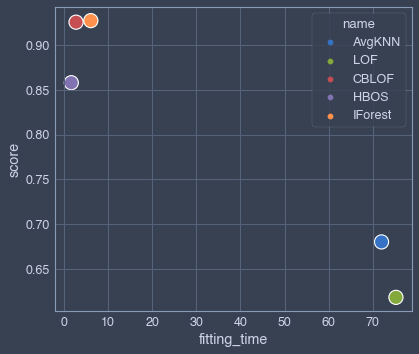

In [29]:
import seaborn as sns

sns.scatterplot(data=training_results, x="fitting_time", y="score", hue="name", s=200)

In [30]:
class VotingEnsemble:
    def __init__(self, estimators):
        self._estimators = estimators
    
    def fit(self, X, y=None):
        for n, e in self._estimators:
            e.fit(X, y)

    def predict_proba(self, X):
        proba = np.zeros((X.shape[0], 2))
        for n, e in self._estimators:
            proba += e.predict_proba(X)
        proba /= len(self._estimators)
        return proba

In [31]:


ensemble_models = [
    {
        "name": "ensemble_all",
        "model": VotingEnsemble(
            estimators=[(model['name'], model['model']) for model in models]
        )
    },
    {
        "name": "ensemble_best",
        "model": VotingEnsemble(
            estimators=[(model['name'], model['model']) for model in models[-3:]]
        )
    },
]
for model in ensemble_models:

    # Evaluate
    y_pred = model["model"].predict_proba(X_test_preprocessed)[:,1]
    model["score"] = roc_auc_score(y_test, y_pred)
    
    print(f" {model['name']}")
    print(f"AUC={model['score']}")
    print("-" * 20)

 ensemble_all
AUC=0.9192373607540703
--------------------
 ensemble_best
AUC=0.9204989050747405
--------------------
